In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import glob
import logging
from pathlib import Path

import mat73
import toml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpyro

from hb_mep.config import HBMepConfig
from hb_mep.data_access import DataClass
from hb_mep.models.rats.saturated_relu import SaturatedReLU
from hb_mep.utils import timing
from hb_mep.utils.constants import (
    INTENSITY,
    RESPONSE,
    PARTICIPANT,
    FEATURES
)

numpyro.set_platform("cpu")
numpyro.set_host_device_count(12)
numpyro.enable_x64()

PARENT_PATH = Path(os.getcwd()).parent.parent.absolute()
FORMAT = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
logging.basicConfig(format=FORMAT, level=logging.INFO)

In [3]:
@timing
def plot(
    df: pd.DataFrame,
    encoder_dict: dict = None,
    pred: pd.DataFrame = None,
    mat: np.ndarray = None,
    time: np.ndarray = None
):
    if pred is not None:
        assert encoder_dict is not None

    if mat is not None:
        assert time is not None

    columns = [PARTICIPANT] + FEATURES
    combinations = \
        df \
        .groupby(by=columns) \
        .size() \
        .to_frame("counts") \
        .reset_index().copy()
    combinations = combinations[columns].apply(tuple, axis=1).tolist()
    n_combinations = len(combinations)

    n_columns = 1 if mat is None else 2

    fig, axes = plt.subplots(
        n_combinations,
        n_columns,
        figsize=(n_columns * 6, n_combinations * 3),
        constrained_layout=True
    )

    for i, c in enumerate(combinations):
        idx = df[columns].apply(tuple, axis=1).isin([c])

        temp_df = df[idx].reset_index(drop=True).copy()

        ax = axes[i] if mat is None else axes[i][0]
        sns.scatterplot(data=temp_df, x=INTENSITY, y=RESPONSE, ax=ax)

        ax.set_xlabel(f"{INTENSITY}")
        ax.set_ylabel(f"{RESPONSE}")

        if encoder_dict is None:
            title = f"{columns} - {c}"
        else:
            c0 = encoder_dict[columns[0]].inverse_transform(np.array([c[0]]))[0]
            c1 = encoder_dict[columns[1]].inverse_transform(np.array([c[1]]))[0]
            c2 = encoder_dict[columns[2]].inverse_transform(np.array([c[2]]))[0]
            title = f"{(c0, c1, c2)}"

        ax.set_title(title)

        if pred is not None:
            temp_pred = pred[pred[columns].apply(tuple, axis=1).isin([(c0, c1, c2)])]
            prediction = temp_pred[RESPONSE].values
            assert len(prediction) == 1
            ax.axvline(
                x=prediction[0],
                color="red",
                linestyle='--',
                alpha=.4,
                label=f"Ahmet's prediction: {prediction[0]}"
            )
            ax.legend(loc="upper right")

        if mat is not None:
            ax = axes[i][1]
            temp_mat = mat[idx, :]

            for j in range(temp_mat.shape[0]):
                x = temp_mat[j, :]/60 + temp_df[INTENSITY].values[j]
                ax.plot(x, time, color="green", alpha=.4)

            ax.axhline(
                y=0.003, color="red", linestyle='--', alpha=.4, label="AUC Window"
            )
            ax.axhline(
                y=0.015, color="red", linestyle='--', alpha=.4
            )

            ax.set_ylim(bottom=-0.001, top=0.02)

            ax.set_xlabel(f"{INTENSITY}")
            ax.set_ylabel(f"Time")

            ax.legend(loc="upper right")
            ax.set_title(f"Motor Evoked Potential")

    return fig

In [4]:
def compound_map(arr, segment_map, laterality_map):
    result = []
    for num in arr:
        if not num:
            result += [np.nan, np.nan]
            continue
        result += [segment_map[num], laterality_map[num]]
    return result

#### Load config

In [5]:
config = HBMepConfig()
config.CURRENT_PATH = PARENT_PATH

#### Load data and preprocess

In [6]:
data = DataClass(config)

nMax = 4
df = None

for i in range(1, nMax):
    participant = f"amap{i:02}"
    PREFIX = f"rats_data/{participant}/*"

    fpath = glob.glob(os.path.join(data.data_path, f"{PREFIX}/*auc_table.csv"))[0]
    temp_df = pd.read_csv(fpath)

    fpath = glob.glob(os.path.join(data.data_path, f"{PREFIX}/*ep_matrix.mat"))[0]
    data_dict = mat73.loadmat(fpath)
    temp_mat = data_dict["ep_sliced"]

    if df is None:
        time = data_dict["t_sliced"]
    else:
        assert((data_dict["t_sliced"] == time).all())

    temp_df["participant"] = participant
    temp_df["segment"] = temp_df.channel2_segment
    temp_df["method"] = temp_df.channel2_laterality

    idx = temp_df.channel1_segment.isna()
    temp_df = temp_df[idx].copy()
    temp_df.reset_index(drop=True, inplace=True)

    temp_mat = temp_mat[idx, :, :]

    if df is None:
        df = temp_df.copy()
        mat = temp_mat
    else:
        df = pd.concat([df, temp_df], ignore_index=True).copy()
        mat = np.vstack((mat, temp_mat))

df.reset_index(drop=True, inplace=True)

df, encoder_dict = data.build(df)


2023-05-24 14:34:53,632 - hb_mep.data_access.core - INFO - Processing data ...
2023-05-24 14:34:53,641 - hb_mep.utils.utils - INFO - func:preprocess took: 0.01 sec
2023-05-24 14:34:53,642 - hb_mep.utils.utils - INFO - func:build took: 0.01 sec


#### Load predictions

In [7]:
pred = None

columns = [
    "channel1_segment", "channel1_laterality",
    "channel2_segment", "channel2_laterality"
]

for i in range(1, nMax):
    participant = f"amap{i:02}"

    PREFIX = f"acute_mapping/data/{participant}"
    fpath = glob.glob(os.path.join(data.data_path, f"{PREFIX}/*stim_compressed.csv"))[0]
    temp_df = pd.read_csv(fpath)

    PREFIX = f"rats_data/{participant}/*"
    fpath = glob.glob(os.path.join(data.data_path, f"{PREFIX}/*cfg_data.toml"))[0]
    meta = toml.load(fpath)

    layout = meta["layout"]
    laterality = meta["electrode_position"]["laterality"]
    segment = meta["electrode_position"]["segment"]

    segment_map = {}
    laterality_map = {}

    for i in range(4):
        for j in range(4):
            segment_map[layout[i][j]] = segment[f"row{i+1}"][j]
            laterality_map[layout[i][j]] = laterality[f"row{i+1}"][j]

    out = temp_df \
        .stim_chs_str \
        .apply(lambda x: x.split("--")) \
        .apply(lambda arr: [int(num) for num in arr]) \
        .apply(lambda arr: compound_map(arr, segment_map, laterality_map))

    temp_df[columns] = pd.DataFrame(out.tolist(), columns=columns)

    idx = temp_df.channel1_segment.isna()
    temp_df = temp_df[idx].copy()
    temp_df.reset_index(drop=True, inplace=True)

    temp_df["participant"] = participant
    temp_df["segment"] = temp_df.channel2_segment
    temp_df["method"] = temp_df.channel2_laterality
    temp_df[config.RESPONSE] = temp_df.Biceps_threshold_peak

    if pred is None:
        pred = temp_df.copy()
    else:
        pred = pd.concat([pred, temp_df], ignore_index=True).copy()

pred.reset_index(drop=True, inplace=True)


#### Plot data

In [8]:
# plot(df, encoder_dict=encoder_dict, mat=mat[:, :, 0], time=time);
# plot(df, encoder_dict=encoder_dict, pred=pred);

#### Initialize model

In [9]:
model = SaturatedReLU(config)

#### Run MCMC inference

In [10]:
mcmc, posterior_samples = model.run_inference(df=df)

2023-05-24 14:34:54,078 - jax._src.xla_bridge - INFO - Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
2023-05-24 14:34:54,078 - jax._src.xla_bridge - INFO - Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-05-24 14:34:54,079 - jax._src.xla_bridge - INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-05-24 14:34:54,079 - jax._src.xla_bridge - INFO - Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
2023-05-24 14:34:54,080 - jax._src.xla_bridge - INFO - Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.
2023-05-24 14:34:54,119 - hb_mep.models.rats.saturated_relu - INFO - Running inference with Saturat

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-05-24 14:42:57,251 - hb_mep.utils.utils - INFO - func:run_inference took: 8 min and 3.18 sec


#### Diagnostics

In [11]:
mcmc.print_summary()


                           mean       std    median      5.0%     95.0%     n_eff     r_hat
             a[0,0,0]    121.27      4.33    122.01    114.99    127.99   2639.11      1.00
             a[0,0,1]     46.61      1.18     46.81     44.84     48.16   6353.42      1.00
             a[0,0,2]     38.93      4.64     40.08     32.67     44.43   3600.99      1.00
             a[0,1,0]    128.57      2.15    128.75    125.53    131.93   7287.42      1.00
             a[0,1,1]    114.88      3.43    115.10    109.58    120.36  12927.73      1.00
             a[0,1,2]    112.91      3.25    112.66    106.18    117.54   4687.72      1.00
             a[0,2,0]    208.02      2.58    208.03    203.63    211.94  11237.35      1.00
             a[0,2,1]    228.05      1.73    228.53    225.67    230.28   5074.11      1.00
             a[0,2,2]    167.67      4.61    168.67    159.65    174.60   4834.80      1.00
             a[0,3,0]    206.33      2.95    206.54    201.58    210.97   5706.

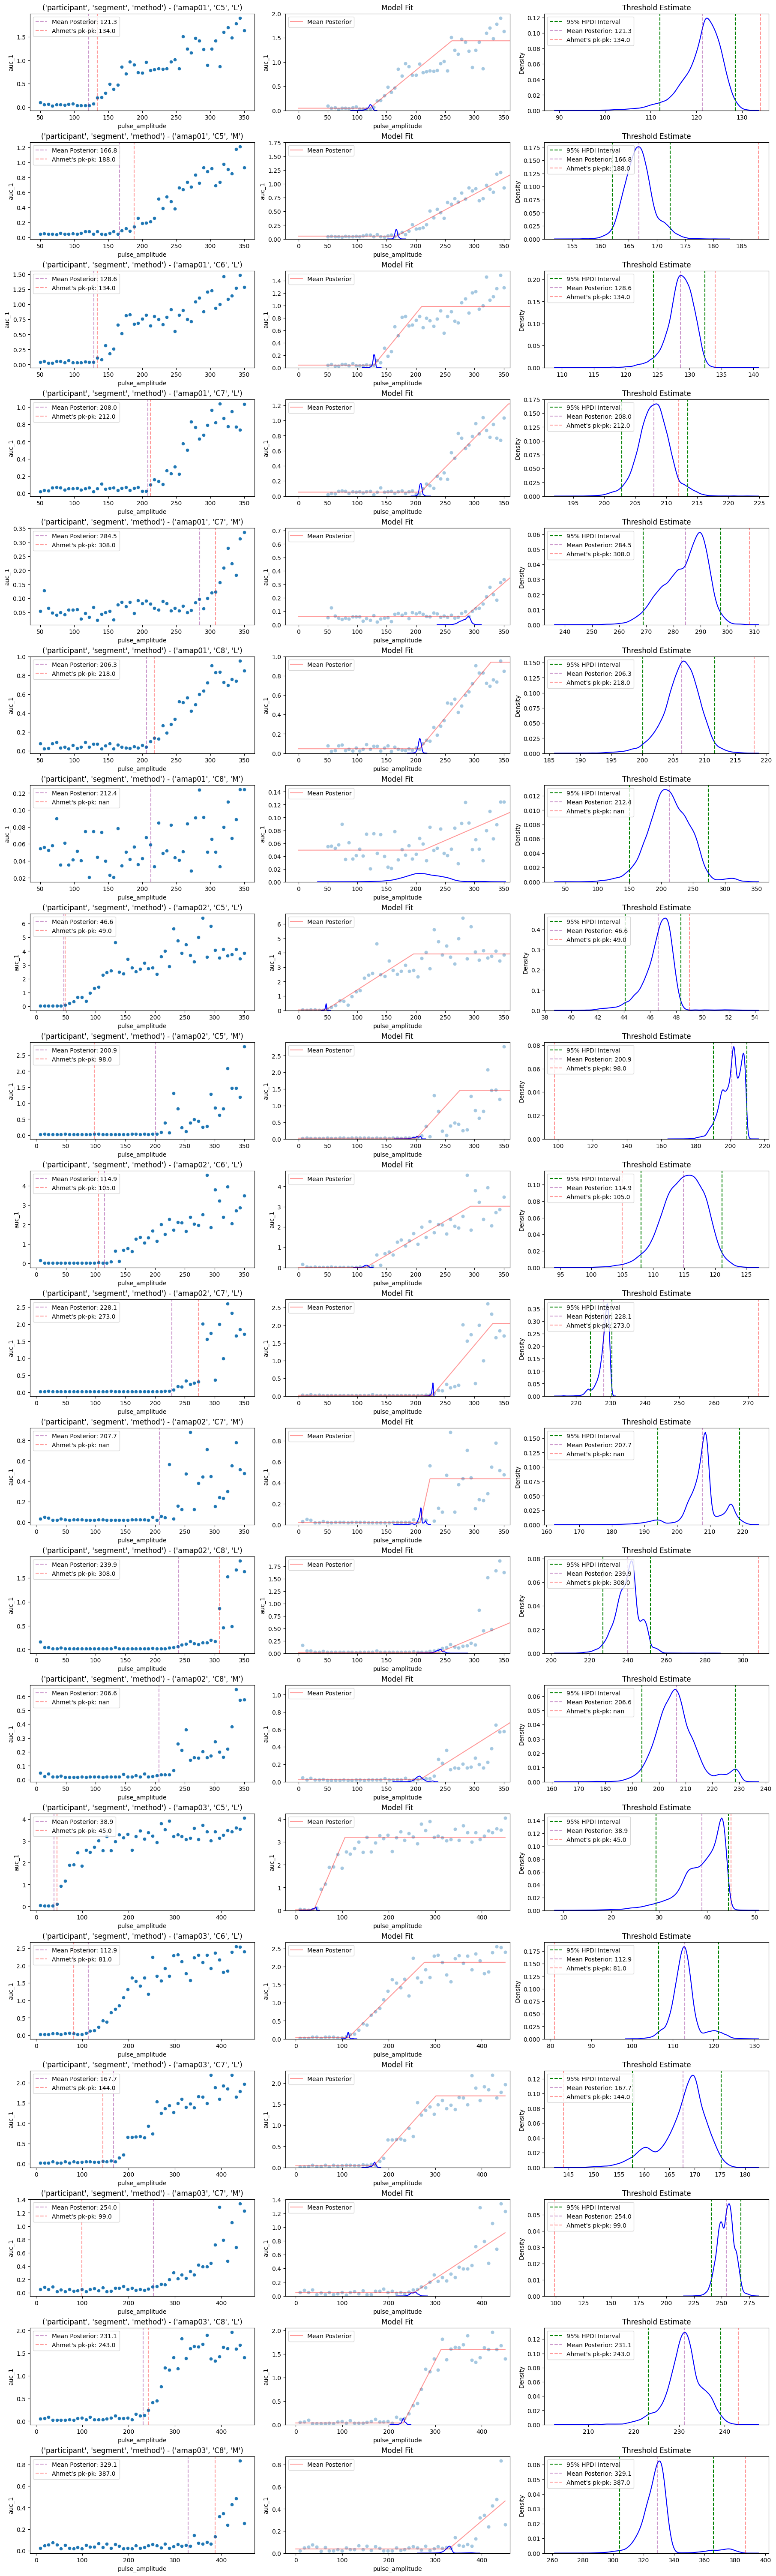

In [12]:
model.plot(df=df, posterior_samples=posterior_samples, encoder_dict=encoder_dict, pred=pred);

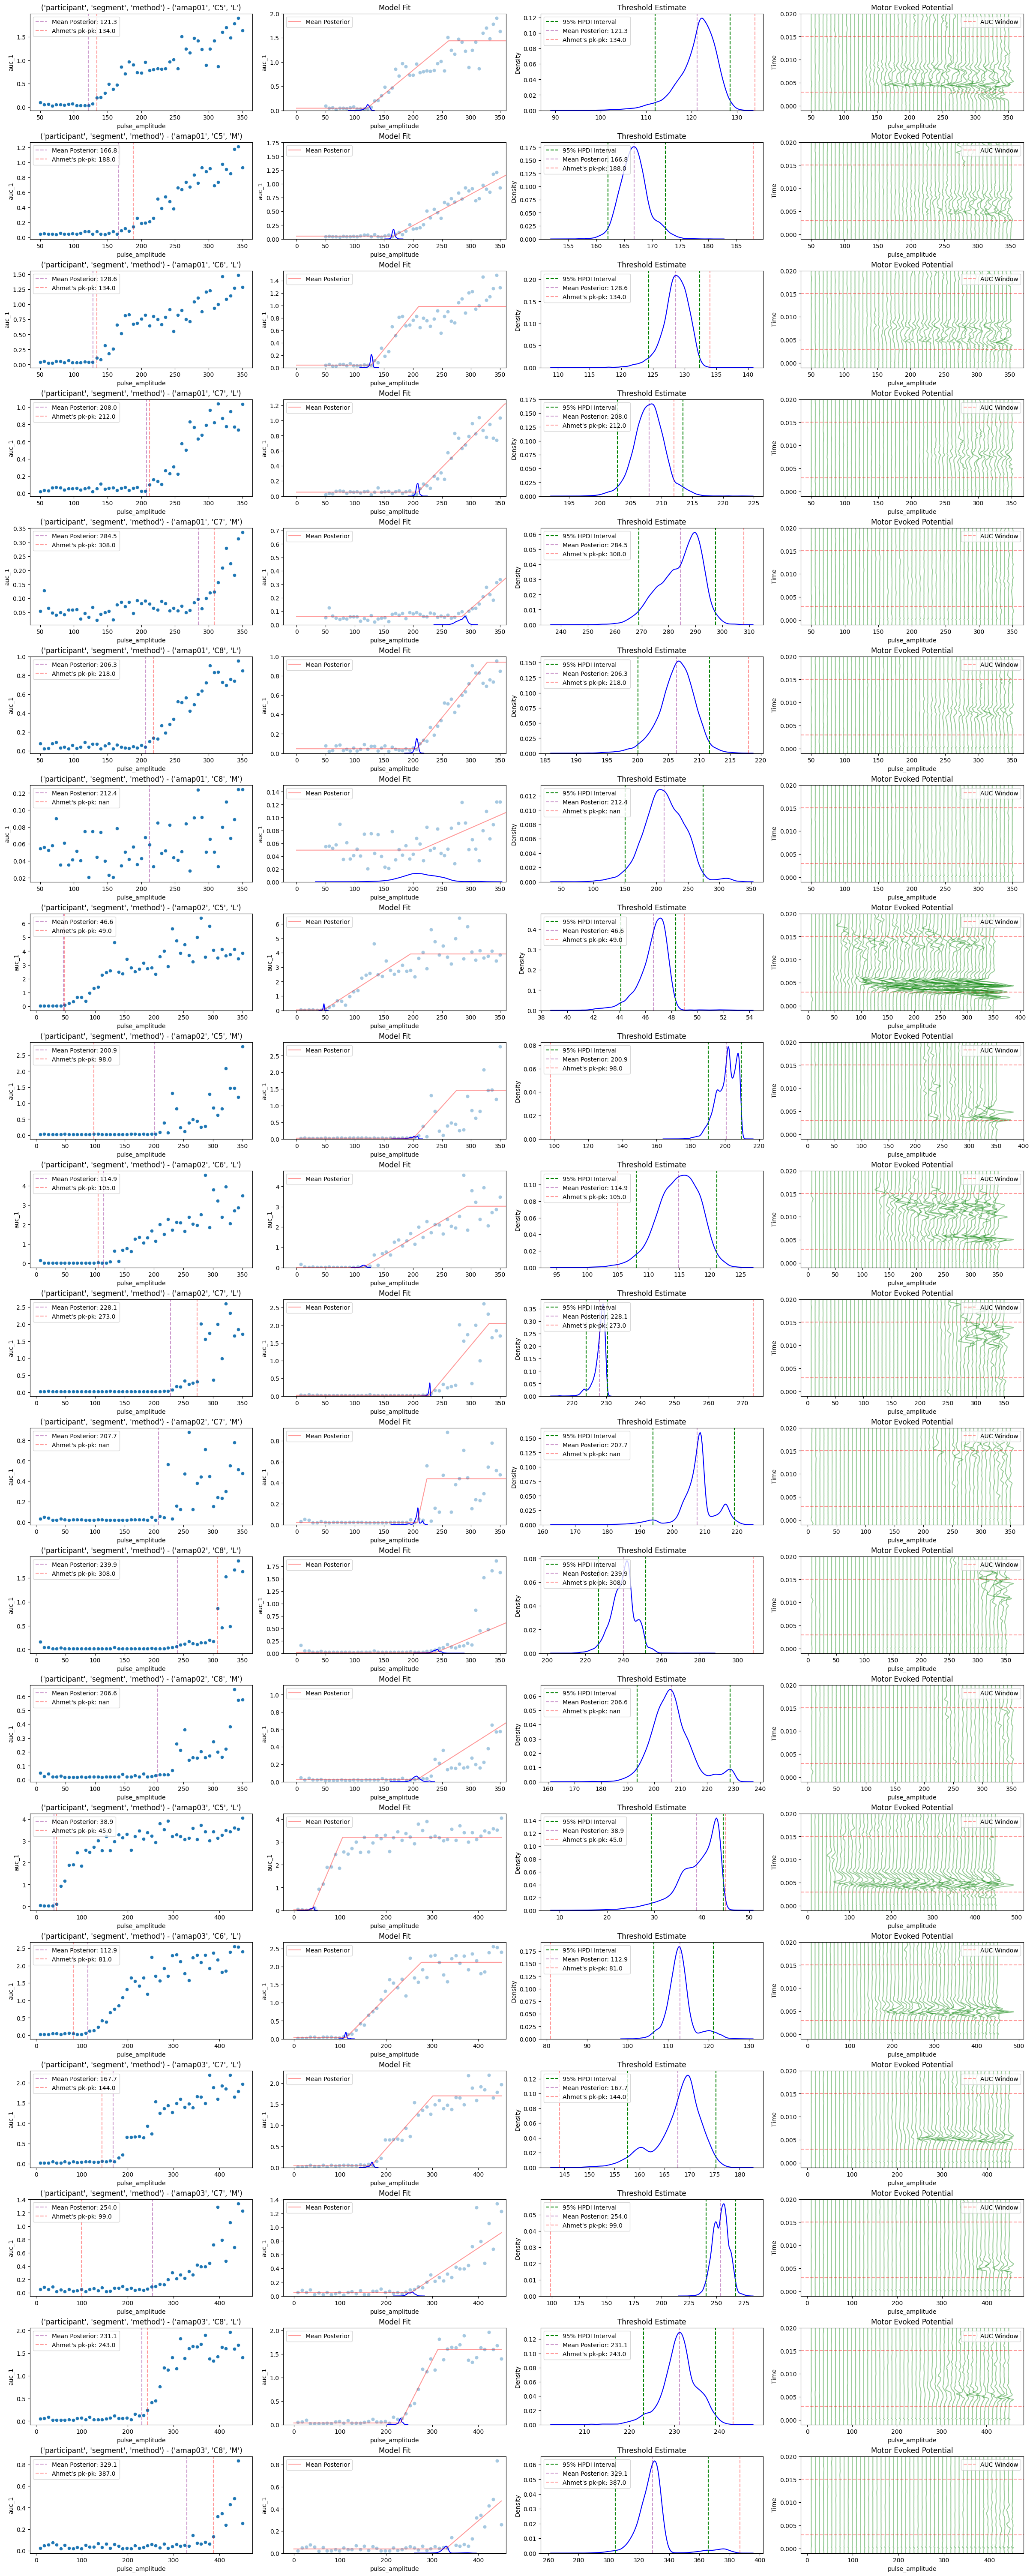

In [13]:
model.plot(df=df, posterior_samples=posterior_samples, encoder_dict=encoder_dict, pred=pred, mat=mat[:,:,0], time=time);